# Quantium Data Analytics - Task 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from scipy import stats

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
path = '/content/gdrive/MyDrive/'

In [4]:
df = pd.read_csv(path+'QVI_data.csv')
df

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream
...,...,...,...,...,...,...,...,...,...,...,...,...
264829,2370701,2018-12-08,88,240378,24,Grain Waves Sweet Chilli 210g,2,7.2,210,GRNWVES,YOUNG FAMILIES,Mainstream
264830,2370751,2018-10-01,88,240394,60,Kettle Tortilla ChpsFeta&Garlic 150g,2,9.2,150,KETTLE,YOUNG FAMILIES,Premium
264831,2370961,2018-10-24,88,240480,70,Tyrrells Crisps Lightly Salted 165g,2,8.4,165,TYRRELLS,OLDER FAMILIES,Budget
264832,2370961,2018-10-27,88,240481,65,Old El Paso Salsa Dip Chnky Tom Ht300g,2,10.2,300,OLD,OLDER FAMILIES,Budget


Julia has asked us to evaluate the performance of a store trial which was performed in stores 77, 86 and 88.

We match trial stores to control stores that are similar in terms of:
- Monthly overall sales revenue
- Monthly number of customers
- Monthly number of transactions per customer

prior to the trial period.

In [5]:
# Inserted a column 'YEARMONTH'
df['DATE'] = pd.to_datetime(df['DATE'])
df["YEARMONTH"] = df["DATE"].dt.strftime("%Y%m").astype("int")

Calculate

1. Total Sales

2. Number of Customers

3. Transactions per Customer

for each store and month.

In [6]:
grouped_df = df.groupby(["STORE_NBR","YEARMONTH"])
tot_sales = grouped_df.TOT_SALES.sum()
n_cust = grouped_df.LYLTY_CARD_NBR.nunique()
ntrans_percust = grouped_df.TXN_ID.size()/n_cust

metric_arrays =  [tot_sales, n_cust, ntrans_percust]
metrics_df = pd.concat(metric_arrays, axis=1)

metrics_df.columns = ['tot_sales', 'n_cust', 'ntrans_percust']
metrics_df = metrics_df.reset_index()
metrics_df

,STORE_NBR,YEARMONTH,tot_sales,n_cust,ntrans_percust
0,1,201807,206.9,49,1.061224
1,1,201808,176.1,42,1.023810
2,1,201809,278.8,59,1.050847
3,1,201810,188.1,44,1.022727
4,1,201811,192.6,46,1.021739
...,...,...,...,...,...
3164,272,201902,395.5,45,1.066667
3165,272,201903,442.3,50,1.060000
3166,272,201904,445.1,54,1.037037
3167,272,201905,314.6,34,1.176471


In [7]:
month_counts = metrics_df.groupby('STORE_NBR').YEARMONTH.nunique().reset_index()
stores_fullobs = month_counts[month_counts.YEARMONTH == 12].STORE_NBR
pretrial_metrics = metrics_df[metrics_df['STORE_NBR'].isin(stores_fullobs)]

# Pre-trial period data
pretrial_metrics = pretrial_metrics.loc[pretrial_metrics.YEARMONTH < 201902]
pretrial_metrics

,STORE_NBR,YEARMONTH,tot_sales,n_cust,ntrans_percust
0,1,201807,206.9,49,1.061224
1,1,201808,176.1,42,1.023810
2,1,201809,278.8,59,1.050847
3,1,201810,188.1,44,1.022727
4,1,201811,192.6,46,1.021739
...,...,...,...,...,...
3159,272,201809,304.7,32,1.125000
3160,272,201810,430.6,44,1.159091
3161,272,201811,376.2,41,1.097561
3162,272,201812,403.9,47,1.000000


We now calculate the correlation between a trial store and all other control stores over pretrial period and output the correlation table.

In [8]:
def calc_corr(trial, metric_col, input_table = pretrial_metrics):
    trial_stores = [77, 86, 88]
    control_stores = stores_fullobs[~stores_fullobs.isin(trial_stores)]
    # Trial store values
    trial_vals = input_table[input_table["STORE_NBR"] == trial][metric_col].reset_index()
    # Create empty correlation table
    corr_table = pd.DataFrame(columns = ['YEARMONTH', 'trial_store', 'control_store', 'correlation'])
    # Loop through all control store
    for control in control_stores:
        control_vals = input_table[input_table["STORE_NBR"] == control][metric_col].reset_index()
        corr_row = pd.DataFrame(columns = ['YEARMONTH', 'trial_store', 'control_store', 'correlation'])
        corr_row.YEARMONTH = list(input_table.loc[input_table.STORE_NBR == control]["YEARMONTH"])
        corr_row.trial_store = trial
        corr_row.control_store = control
        corr_row.correlation = control_vals.corrwith(trial_vals, axis=1)
        corr_table = pd.concat([corr_table, corr_row])
    return (corr_table)

In [9]:
trial_stores = [77, 86, 88]
corr_table = pd.DataFrame(columns = ['YEARMONTH', 'trial_store', 'control_store', 'correlation'])
for store in trial_stores:
    corr_section = calc_corr(store, ['tot_sales', 'n_cust', 'ntrans_percust'])
    corr_table = pd.concat([corr_table, corr_section])

<ipython-input-8-35cb5c0e936e>:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  corr_table = pd.concat([corr_table, corr_row])
<ipython-input-9-fb2ff11bb0c3>:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  corr_table = pd.concat([corr_table, corr_section])
<ipython-input-8-35cb5c0e936e>:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes

In [10]:
corr_table

,YEARMONTH,trial_store,control_store,correlation
0,201807,77,1,-0.127100
1,201808,77,1,-0.171779
2,201809,77,1,-0.191927
3,201810,77,1,-0.217780
4,201811,77,1,-0.169064
...,...,...,...,...
2,201809,88,272,0.435983
3,201810,88,272,0.501235
4,201811,88,272,0.472945
5,201812,88,272,0.506498


We also calculate the magnitude distance (normalized between 0 and 1) and output a correlation table.

In [11]:
def calc_magdist(trial, metric_col, input_table = pretrial_metrics):
    trial_stores = [77, 86, 88]
    control_stores = stores_fullobs[~stores_fullobs.isin(trial_stores)]
    # Store calculated magnitude
    dist_table = pd.DataFrame()
    # Loop through all control store
    for control in control_stores:
        dist_row = pd.DataFrame()
        # Calculate the absolute value - subtract the metric values of the control store from the trial store for each month
        dist_row = abs(input_table[input_table["STORE_NBR"] == trial].reset_index()[metric_col]\
                        - input_table[input_table["STORE_NBR"] == control].reset_index()[metric_col])
        dist_row.insert(0,'YEARMONTH', list(input_table.loc[input_table.STORE_NBR == trial]["YEARMONTH"]))
        dist_row.insert(1,'trial_store', trial)
        dist_row.insert(2,'control_store', control)
        dist_table = pd.concat([dist_table, dist_row])

    # Normalize distances
    for col in metric_col:
        maxdist = dist_table[col].max()
        mindist = dist_table[col].min()
        dist_table[col] = 1-(dist_table[col] - mindist)/(maxdist-mindist)
    # Calculate average magnitude distance across all metrics
    dist_table['mag_measure'] = dist_table[metric_col].mean(axis=1)
    return (dist_table)

Now we select control stores based on how similar their performance is to the trial stores using:

1. Total Sales

2. Number of Customers

by calculating:

1. Correlation Score for Total Sales and Number of Customers

2. Magnitude Distance for Total Sales and Number of Customers

and output the averaged correlations, magnitude distances, and a combined score.

In [12]:
def calc_corrdist_score (trial, metric_col, input_table=pretrial_metrics):
    corr_vals = calc_corr(trial, metric_col, input_table)
    mag_vals = calc_magdist(trial, metric_col, input_table)
    mag_vals = mag_vals.drop(metric_col, axis=1)

    combined_corr_dist = pd.merge(corr_vals, mag_vals, on=["YEARMONTH", "trial_store", "control_store"])

    # Average correlations and distances
    avg_corrmag = combined_corr_dist.groupby(["trial_store", "control_store"]).mean().reset_index()

    # Combined score: take the weighted average of the correlation and magnitude
    corr_weight = 0.5
    avg_corrmag['combined_score'] = corr_weight*avg_corrmag['correlation'] + (1-corr_weight)*avg_corrmag['mag_measure']
    return(avg_corrmag)

In [13]:
# Top 5 control stores
def find_highestscore(trial):
    scores_tot_sales = calc_corrdist_score (trial, ['tot_sales'])
    scores_n_cust = calc_corrdist_score (trial, ['n_cust'])

    scores_control = pd.DataFrame()
    scores_control['control_store'] = scores_tot_sales.control_store
    # Calculate the composite scores
    scores_control['correlation'] = 0.5*scores_tot_sales.correlation + 0.5*scores_n_cust.correlation
    scores_control['mag_measure'] = 0.5*scores_tot_sales.mag_measure + 0.5*scores_n_cust.mag_measure
    scores_control['scores'] = 0.5*scores_tot_sales.combined_score + 0.5*scores_n_cust.combined_score
    return(scores_control.sort_values(by = 'scores', ascending = False).reset_index(drop = True).head(5))

In [14]:
# Find ultimate control stores with the highest scores for each trial stores
trial_stores = [77, 86, 88]
for trial in trial_stores:
    print('Trial store: ', trial)
    print(find_highestscore(trial))
    print()

Trial store:  77


<ipython-input-8-35cb5c0e936e>:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  corr_table = pd.concat([corr_table, corr_row])
<ipython-input-8-35cb5c0e936e>:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  corr_table = pd.concat([corr_table, corr_row])


   control_store  correlation  mag_measure    scores
0            233          1.0     0.989804  0.994902
1             41          1.0     0.972041  0.986020
2             46          1.0     0.969523  0.984762
3             53          1.0     0.968421  0.984211
4            111          1.0     0.967981  0.983991

Trial store:  86


<ipython-input-8-35cb5c0e936e>:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  corr_table = pd.concat([corr_table, corr_row])
<ipython-input-8-35cb5c0e936e>:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  corr_table = pd.concat([corr_table, corr_row])


   control_store  correlation  mag_measure    scores
0            155          1.0     0.976324  0.988162
1            109          1.0     0.968180  0.984090
2            225          1.0     0.965044  0.982522
3            229          1.0     0.957995  0.978997
4            101          1.0     0.945394  0.972697

Trial store:  88


<ipython-input-8-35cb5c0e936e>:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  corr_table = pd.concat([corr_table, corr_row])
<ipython-input-8-35cb5c0e936e>:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  corr_table = pd.concat([corr_table, corr_row])


   control_store  correlation  mag_measure    scores
0             40          1.0     0.941789  0.970895
1             26          1.0     0.917859  0.958929
2             72          1.0     0.908157  0.954079
3             58          1.0     0.900435  0.950217
4             81          1.0     0.887572  0.943786



The stores with the highest scores:

- Store 233 for trial store 77

- Store 155 for trial store 86

- Store 40 for trial stre 88

In [15]:
# @title Default title text
def make_plots(storepair, metric_col):
    trial = storepair[0]
    control = storepair[1]
    trial_plot = pretrial_metrics[pretrial_metrics.STORE_NBR == trial][['YEARMONTH', 'STORE_NBR', metric_col]]
    trial_plot = trial_plot.rename(columns = {metric_col: metric_col+'_trial'})
    control_plot = pretrial_metrics[pretrial_metrics.STORE_NBR == control][['YEARMONTH', 'STORE_NBR', metric_col]]
    control_plot = control_plot.rename(columns = {metric_col: metric_col+'_control'})

    other_stores = pretrial_metrics.loc[(pretrial_metrics.STORE_NBR != trial) & (pretrial_metrics.STORE_NBR != control)][['YEARMONTH', 'STORE_NBR', metric_col]]

    # average performance of other stores
    plot_other = other_stores.groupby('YEARMONTH')[metric_col].mean()

    ax = control_plot.plot.line(x = "YEARMONTH", y = metric_col+'_control', use_index=False, label = 'Control '+metric_col)
    ax_trial = trial_plot.plot.line(x = "YEARMONTH", y = metric_col+'_trial', use_index=False, ax=ax, label = 'Trial '+metric_col)
    ax_other = plot_other.plot.line(use_index = False, ax=ax, label = 'Other '+ metric_col)
    ax.set_ylabel(metric_col)
    plt.legend(title = 'STORE_NBR', loc = "upper left",bbox_to_anchor=(1.0, 1.0))
    positions = (0,1,2,3,4,5,6)
    labels = ("201807", '201808', '201809', '201810', '201811', '201812', '201901')
    plt.xticks (positions, labels)
    titlestr = 'Trial Store ' + str(storepair[0]) + ' and Control Store ' + str(storepair[1]) + ' in the Pre-Trial Period'
    ax.set_title(titlestr)


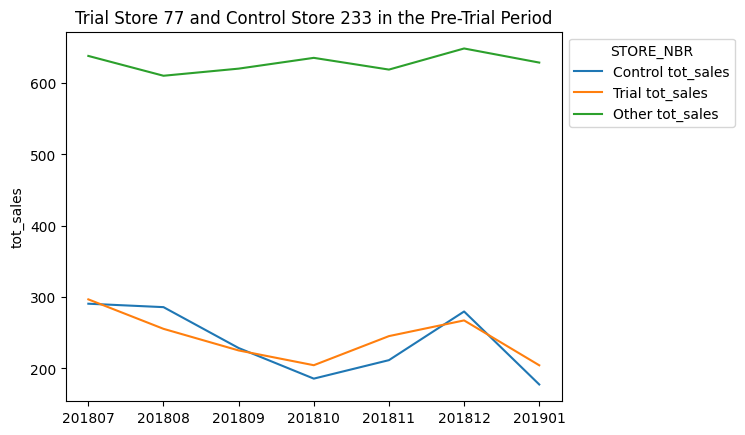

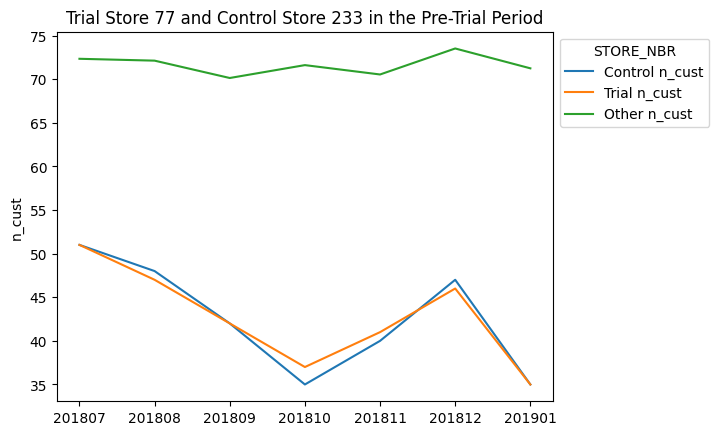

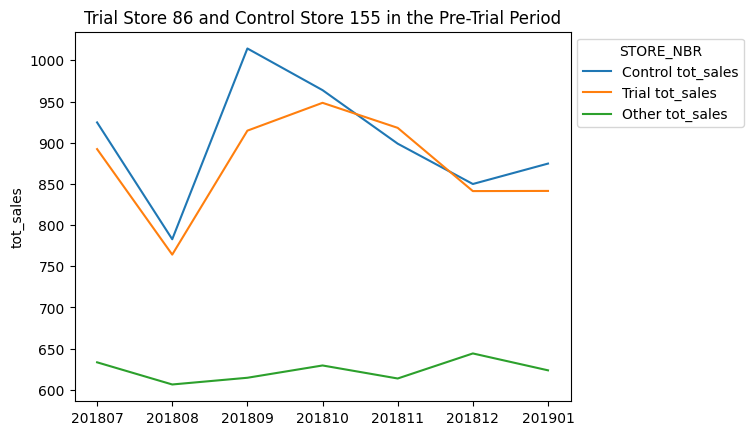

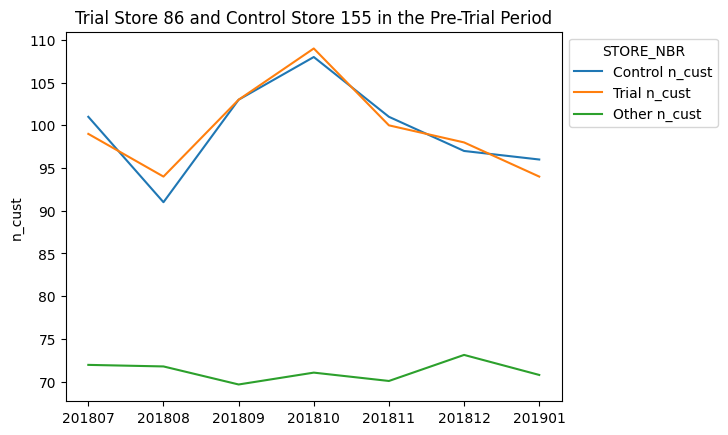

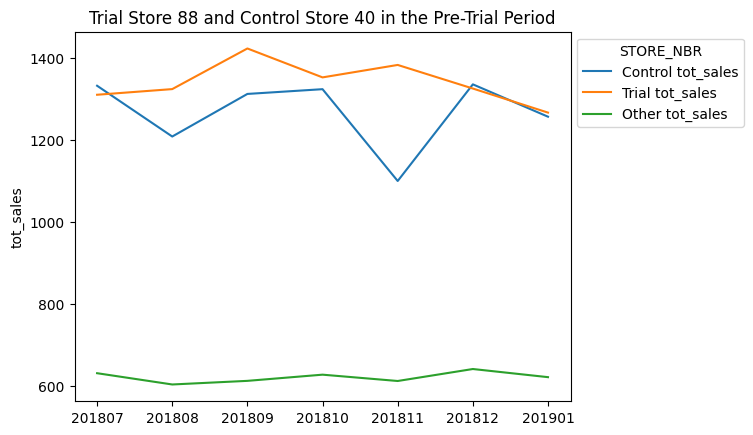

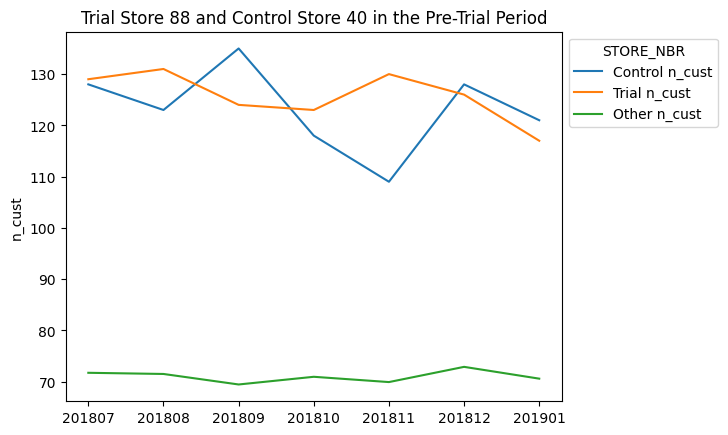

In [16]:
storepair = [[77, 233], [86, 155], [88, 40]]
metric_col = ['tot_sales', 'n_cust']
for pair in storepair:
    for metric in metric_col:
        make_plots(pair, metric)

The metrics of the control and trial stores look pretty similar in the pre-trial period.

We now determine if there's an uplift in overall chip sales by scaling the control store's sales during trial period.

In [17]:
# Calculate scaling factor for the store pairs
# divide the total sales of the trial store by the total sales of the corresponding control store during the pre-trial period
scale_store77 = pretrial_metrics[pretrial_metrics.STORE_NBR == 77]['tot_sales'].sum()/pretrial_metrics[pretrial_metrics.STORE_NBR == 233]['tot_sales'].sum()
scale_store86 = pretrial_metrics[pretrial_metrics.STORE_NBR == 86]['tot_sales'].sum()/pretrial_metrics[pretrial_metrics.STORE_NBR == 155]['tot_sales'].sum()
scale_store88 = pretrial_metrics[pretrial_metrics.STORE_NBR == 88]['tot_sales'].sum()/pretrial_metrics[pretrial_metrics.STORE_NBR == 40]['tot_sales'].sum()

Then, we compare the scaled sales of control stores during the trial period to the actual sales of the trial stores for the same period

In [18]:
scaled_control233 = metrics_df[metrics_df.STORE_NBR.isin([233])][['STORE_NBR', "YEARMONTH", 'tot_sales']]
scaled_control233.tot_sales *= scale_store77
scaled_control155 = metrics_df[metrics_df.STORE_NBR.isin([155])][['STORE_NBR', "YEARMONTH", 'tot_sales']]
scaled_control155.tot_sales *= scale_store86
scaled_control40 = metrics_df[metrics_df.STORE_NBR.isin([40])][['STORE_NBR', "YEARMONTH", 'tot_sales']]
scaled_control40.tot_sales *= scale_store88

scaledsales_control = pd.concat([scaled_control233, scaled_control155, scaled_control40]).reset_index(drop = True)
scaledsales_control = scaledsales_control.rename(columns = {'tot_sales':'scaled_tot_sales', 'STORE_NBR': 'CONTROL_NBR'})
scaledsales_control_trial = scaledsales_control[(scaledsales_control.YEARMONTH>=201902) & (scaledsales_control.YEARMONTH<=201904)].reset_index(drop = True)

trialsales = metrics_df[metrics_df.STORE_NBR.isin([77,86,88])][['STORE_NBR', "YEARMONTH", 'tot_sales']].reset_index(drop = True)
trialsales = trialsales.rename(columns = {'STORE_NBR': 'TRIAL_NBR'})
trialsales_trial = trialsales[(trialsales.YEARMONTH >= 201902) & (trialsales.YEARMONTH <= 201904)].reset_index(drop = True)

We can calculate the percentage difference between the scaled control sales and the trial store's sales during the trial period.

In [19]:
percentdiff = scaledsales_control.copy()
percentdiff[['TRIAL_NBR', 'tot_sales_t']] = trialsales[['TRIAL_NBR', 'tot_sales']]
percentdiff = percentdiff.rename(columns = {'scaled_tot_sales' : 'scaled_sales_c'})
percentdiff['sales_percent_diff'] = (percentdiff.tot_sales_t-percentdiff.scaled_sales_c)\
                                    /(0.5*((percentdiff.scaled_sales_c+percentdiff.tot_sales_t)))
percentdiff

,CONTROL_NBR,YEARMONTH,scaled_sales_c,TRIAL_NBR,tot_sales_t,sales_percent_diff
0,233,201807,297.565550,77,296.80,-0.002576
1,233,201808,292.652187,77,255.50,-0.135554
2,233,201809,233.998916,77,225.20,-0.038323
3,233,201810,190.085733,77,204.50,0.073060
4,233,201811,216.597421,77,245.30,0.124281
5,233,201812,286.408121,77,267.30,-0.069019
6,233,201901,181.692071,77,204.40,0.117630
7,233,201902,249.762622,77,235.00,-0.060907
8,233,201903,203.802205,77,278.50,0.309755
9,233,201904,162.345704,77,263.50,0.475075


We can see if the difference is significant using a t-test.

Our null hypothesis is that the trial period is the same as the pre-trial period - a 0-percent between the trial and control stores.

In [20]:
# take standard deviation based on the scaled percentage difference in the pre-trial period
pretrial_percentdiff = percentdiff[percentdiff.YEARMONTH < 201902]
pretrial_percentdiff_std = pretrial_percentdiff.groupby(['TRIAL_NBR'])['sales_percent_diff'].agg('std').reset_index()
dof = 6

for stores in storepair:
    trialstore = stores[0]
    controlstore = stores[1]
    pretrial = percentdiff[(percentdiff.YEARMONTH < 201902) & (percentdiff.TRIAL_NBR == trialstore)]
    std = pretrial['sales_percent_diff'].agg('std')
    mean =  pretrial['sales_percent_diff'].agg('mean')
    trialperiod = percentdiff[(percentdiff.YEARMONTH >= 201902) & (percentdiff.YEARMONTH <= 201904) \
                              & (percentdiff.TRIAL_NBR == trialstore)]
    print("Trial store -", trialstore, "; control store -", controlstore)
    print("Month : t-statistic")
    for month in trialperiod.YEARMONTH.unique():
        xval = trialperiod[trialperiod.YEARMONTH == month]['sales_percent_diff'].item()
        tstat = ((xval - mean)/std)
        print(str(month), ' : ', tstat)
    print()

print ('95th percentile value:', stats.t.ppf(1-0.05, 6))

Trial store - 77 ; control store - 233
Month : t-statistic
201902  :  -0.7171038288055838
201903  :  3.035317928855674
201904  :  4.708944418758219

Trial store - 86 ; control store - 155
Month : t-statistic
201902  :  1.4133618775921597
201903  :  7.123063846042147
201904  :  0.8863824572944234

Trial store - 88 ; control store - 40
Month : t-statistic
201902  :  -0.5481633746817577
201903  :  1.0089992743637823
201904  :  0.9710006270463672

95th percentile value: 1.9431802805153022


The t-value for trial store 77 has a much larger 95th percentile value than for March and April, which means that the increase in sales in March and April for trail store are statistically greater than in the control store. This is also true for trial store 8 in March.

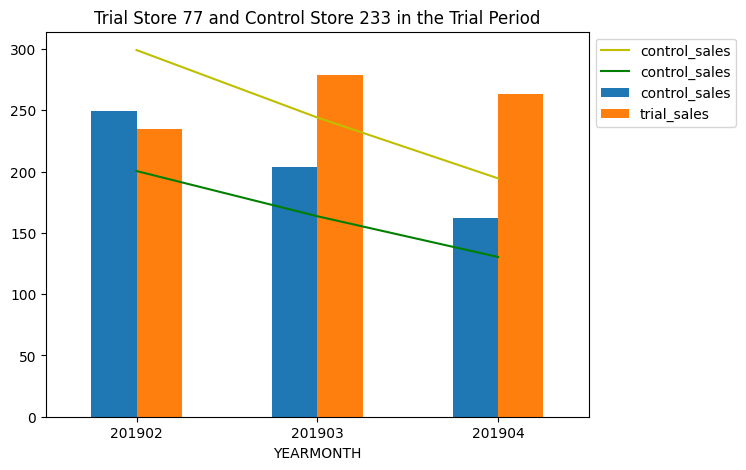

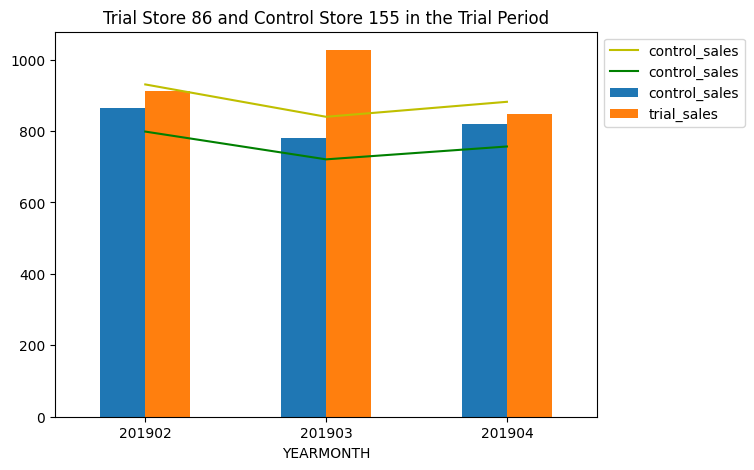

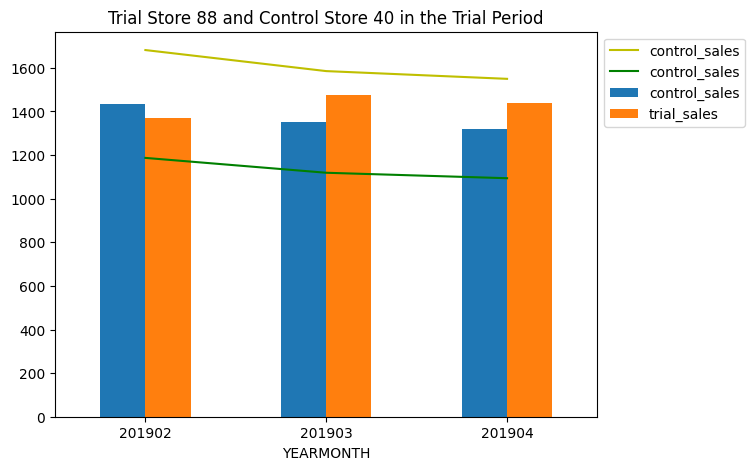

In [21]:
storepair = [[77, 233], [86, 155], [88, 40]]
for stores in storepair:
    trial = stores[0]
    control = stores[1]

    # Total Sales performance
    plot_control = percentdiff[(percentdiff['CONTROL_NBR'] == control) & (percentdiff.YEARMONTH >= 201902) & (percentdiff.YEARMONTH <= 201904)]\
                    [['YEARMONTH', 'CONTROL_NBR', 'scaled_sales_c']]
    plot_control = plot_control.rename(columns = {"CONTROL_NBR" : "STORE_NBR", "scaled_sales_c": "control_sales"})
    plot_trial = percentdiff[(percentdiff['TRIAL_NBR'] == trial) & (percentdiff.YEARMONTH >= 201902) & (percentdiff.YEARMONTH <= 201904)]\
                    [['YEARMONTH', 'TRIAL_NBR', 'tot_sales_t']]
    plot_trial = plot_trial.rename(columns = {"TRIAL_NBR" : "STORE_NBR", "tot_sales_t": "trial_sales"})
    toplot = plot_control[["YEARMONTH", "control_sales"]].merge(plot_trial[["YEARMONTH", "trial_sales"]],on="YEARMONTH").set_index("YEARMONTH")
    ax = toplot.plot(kind = 'bar',  figsize=(7, 5))

    # Thresholds
    std = percentdiff[(percentdiff['CONTROL_NBR'] == control) & (percentdiff.YEARMONTH < 201902)]['sales_percent_diff'].std()
    threshold95 = plot_control.reset_index()[['YEARMONTH', 'control_sales']]
    threshold95.control_sales = threshold95.control_sales*(1+std*2)
    threshold5 = plot_control.reset_index()[['YEARMONTH', 'control_sales']]
    threshold5.control_sales = threshold5.control_sales*(1-std*2)
    ax95 = threshold95.plot.line(x = 'YEARMONTH', y = 'control_sales',color='y', figsize=(7, 5), use_index=False, ax = ax)
    ax5 = threshold5.plot.line(x = 'YEARMONTH', y = 'control_sales', color='g', figsize=(7, 5), use_index=False, ax = ax)

    plt.legend(loc = "upper left",bbox_to_anchor=(1.0, 1.0))
    titlestr = 'Trial Store ' + str(trial) + ' and Control Store ' + str(control) + ' in the Trial Period'
    ax.set_title(titlestr)
    plt.show()

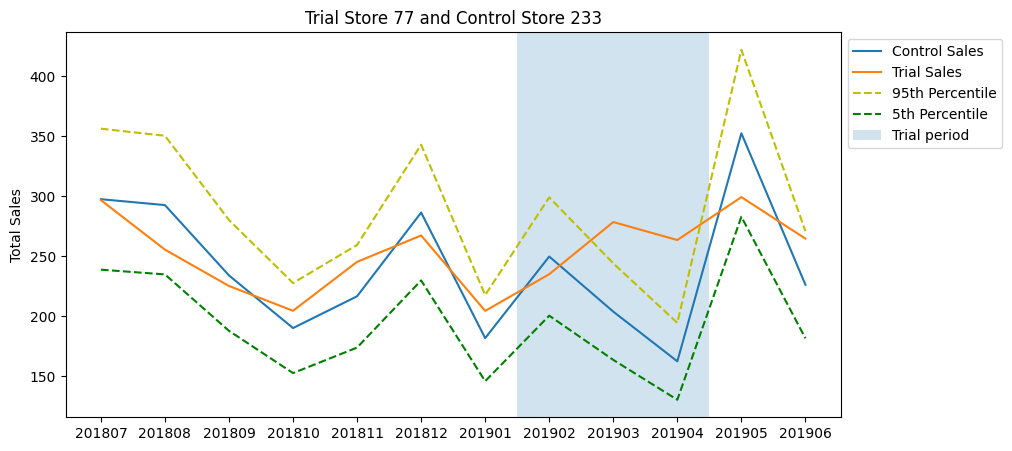

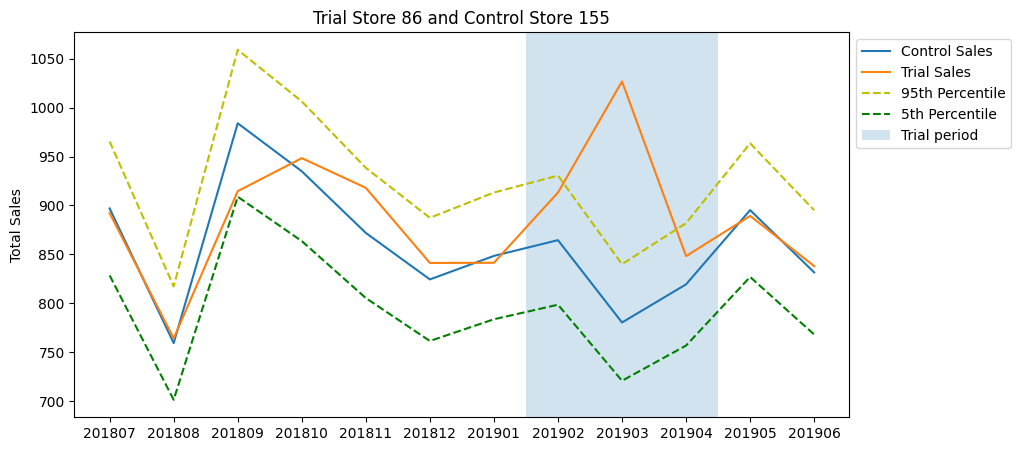

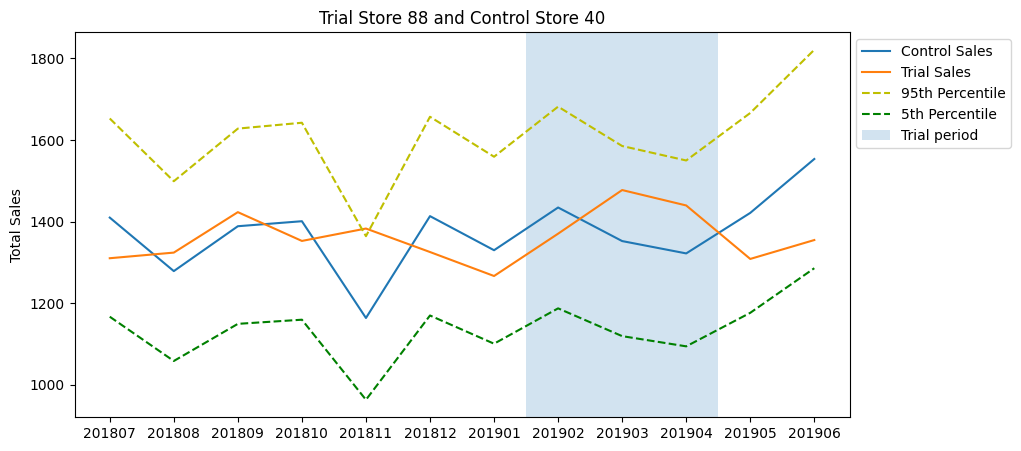

In [22]:
from matplotlib.patches import Rectangle
storepair = [[77, 233], [86, 155], [88, 40]]
for stores in storepair:
    trial = stores[0]
    control = stores[1]
    plot_control = percentdiff[(percentdiff['CONTROL_NBR'] == control)][['YEARMONTH', 'CONTROL_NBR', 'scaled_sales_c']]
    plot_control = plot_control.rename(columns = {"CONTROL_NBR" : "STORE_NBR", "scaled_sales_c": "control_sales"})
    plot_trial = percentdiff[(percentdiff['TRIAL_NBR'] == trial)][['YEARMONTH', 'TRIAL_NBR', 'tot_sales_t']]
    plot_trial = plot_trial.rename(columns = {"TRIAL_NBR" : "STORE_NBR", "tot_sales_t": "trial_sales"})

    ax = plot_control.plot.line(x = "YEARMONTH", y = 'control_sales', use_index=False, label = 'Control Sales')
    ax_trial = plot_trial.plot.line(x = "YEARMONTH", y = 'trial_sales', use_index=False, ax=ax, label = 'Trial Sales')


    # Thresholds
    std = percentdiff[(percentdiff['CONTROL_NBR'] == control) & (percentdiff.YEARMONTH < 201902)]['sales_percent_diff'].std()
    threshold95 = plot_control.reset_index()[['YEARMONTH', 'control_sales']]
    threshold95.control_sales = threshold95.control_sales*(1+std*2)
    threshold5 = plot_control.reset_index()[['YEARMONTH', 'control_sales']]
    threshold5.control_sales = threshold5.control_sales*(1-std*2)
    ax95 = threshold95.plot.line(x = 'YEARMONTH', y = 'control_sales',color='y', linestyle = '--', figsize=(10, 5), use_index=False, ax = ax, label = '95th Percentile')
    ax5 = threshold5.plot.line(x = 'YEARMONTH', y = 'control_sales', color='g',  linestyle = '--', figsize=(10, 5), use_index=False, ax = ax, label = '5th Percentile')
    ax.add_patch(Rectangle((6.5, 0), 3, 2000, alpha = 0.2, label = 'Trial period'))

    ax.set_ylabel('Total Sales')
    plt.legend(loc = "upper left",bbox_to_anchor=(1.0, 1.0))
    titlestr = 'Trial Store ' + str(trial) + ' and Control Store ' + str(control)
    positions = (0,1,2,3,4,5,6,7,8,9, 10, 11)
    labels = ("201807", '201808', '201809', '201810', '201811', '201812', '201901', '201902', '201903', '201904', '201905', '201906')
    plt.xticks (positions, labels)
    ax.set_title(titlestr)
    plt.show()

The results show that the trial in store 77 is significantly different to its
control store in the trial period as the trial store performance lies outside the
5% to 95% confidence interval of the control store in two of the three trial
months.

For store 86, we can see that the trial in March is significantly different to the control store with the total sales performance outside of the 5% to 95% confidence interval. However, there is no significant difference in February's and April's performance.

The results for store 88 show no significant difference between the trial and control stores during this period.

For number of customers:

In [23]:
# Calculate the scaling factor for the store pairs
scale_store77 = pretrial_metrics[pretrial_metrics.STORE_NBR == 77]['n_cust'].sum()/pretrial_metrics[pretrial_metrics.STORE_NBR == 233]['n_cust'].sum()
scale_store86 = pretrial_metrics[pretrial_metrics.STORE_NBR == 86]['n_cust'].sum()/pretrial_metrics[pretrial_metrics.STORE_NBR == 155]['n_cust'].sum()
scale_store88 = pretrial_metrics[pretrial_metrics.STORE_NBR == 88]['n_cust'].sum()/pretrial_metrics[pretrial_metrics.STORE_NBR == 40]['n_cust'].sum()

In [24]:
scaled_control233 = metrics_df[metrics_df.STORE_NBR.isin([233])][['STORE_NBR', "YEARMONTH", 'n_cust']]
scaled_control233.n_cust *= scale_store77
scaled_control155 = metrics_df[metrics_df.STORE_NBR.isin([155])][['STORE_NBR', "YEARMONTH", 'n_cust']]
scaled_control155.n_cust *= scale_store86
scaled_control40 = metrics_df[metrics_df.STORE_NBR.isin([40])][['STORE_NBR', "YEARMONTH", 'n_cust']]
scaled_control40.n_cust *= scale_store88

scaledncust_control = pd.concat([scaled_control233, scaled_control155, scaled_control40]).reset_index(drop = True)
scaledncust_control = scaledncust_control.rename(columns = {'n_cust':'scaled_n_cust', 'STORE_NBR': 'CONTROL_NBR'})
scaledncust_control_trial = scaledncust_control[(scaledsales_control.YEARMONTH>=201902) & (scaledsales_control.YEARMONTH<=201904)].reset_index(drop = True)

trialncust = metrics_df[metrics_df.STORE_NBR.isin([77,86,88])][['STORE_NBR', "YEARMONTH", 'n_cust']].reset_index(drop = True)
trialncust = trialncust.rename(columns = {'STORE_NBR': 'TRIAL_NBR'})
trialncust_trial = trialncust[(trialncust.YEARMONTH >= 201902) & (trialsales.YEARMONTH <= 201904)].reset_index(drop = True)

In [25]:
# Calculate the percentage difference between the control and trial store pairs for each month over the year
percentdiff = scaledncust_control.copy()
percentdiff[['TRIAL_NBR', 'n_cust_t']] = trialncust[['TRIAL_NBR', 'n_cust']]
percentdiff = percentdiff.rename(columns = {'scaled_n_cust' : 'scaled_n_cust_c'})
percentdiff['cust_percent_diff'] = (percentdiff.n_cust_t-percentdiff.scaled_n_cust_c)\
                                    /(0.5*((percentdiff.scaled_n_cust_c+percentdiff.n_cust_t)))
percentdiff.head()

,CONTROL_NBR,YEARMONTH,scaled_n_cust_c,TRIAL_NBR,n_cust_t,cust_percent_diff
0,233,201807,51.171141,77,51,-0.003350
1,233,201808,48.161074,77,47,-0.024402
2,233,201809,42.140940,77,42,-0.003350
3,233,201810,35.117450,77,37,0.052208
4,233,201811,40.134228,77,41,0.021342


In [26]:

# take the standard deviation based on the scaled percentage difference in the pre-trial period
pretrial_percentdiff = percentdiff[percentdiff.YEARMONTH < 201902]
pretrial_percentdiff_std = pretrial_percentdiff.groupby(['TRIAL_NBR'])['cust_percent_diff'].agg('std').reset_index()
dof = 6

for stores in storepair:
    trialstore = stores[0]
    controlstore = stores[1]
    pretrial = percentdiff[(percentdiff.YEARMONTH < 201902) & (percentdiff.TRIAL_NBR == trialstore)]
    std = pretrial['cust_percent_diff'].agg('std')
    mean =  pretrial['cust_percent_diff'].agg('mean')
    trialperiod = percentdiff[(percentdiff.YEARMONTH >= 201902) & (percentdiff.YEARMONTH <= 201904) \
                              & (percentdiff.TRIAL_NBR == trialstore)]
    print("Trial store -", trialstore, "; control store -", controlstore)
    print("Month : t-statistic")
    for month in trialperiod.YEARMONTH.unique():
        xval = trialperiod[trialperiod.YEARMONTH == month]['cust_percent_diff'].item()
        tstat = ((xval - mean)/std)
        print(str(month), ' : ', tstat)
    print()

print ('95th percentile value:', stats.t.ppf(1-0.05, 6))

Trial store - 77 ; control store - 233
Month : t-statistic
201902  :  -0.19886295797440687
201903  :  8.009609025380932
201904  :  16.114474772873923

Trial store - 86 ; control store - 155
Month : t-statistic
201902  :  6.220524882227514
201903  :  10.52599074274189
201904  :  3.0763575852842706

Trial store - 88 ; control store - 40
Month : t-statistic
201902  :  -0.3592881735131531
201903  :  1.2575196020616801
201904  :  0.6092905590514273

95th percentile value: 1.9431802805153022


there are statistically significant increases in the number of customers in stores 77 and 86 in at March and April during the trial period. However, there is no significant increase in store 88.  

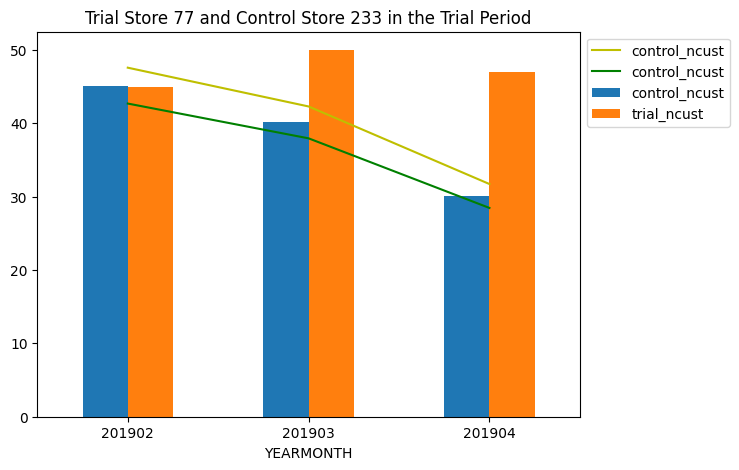

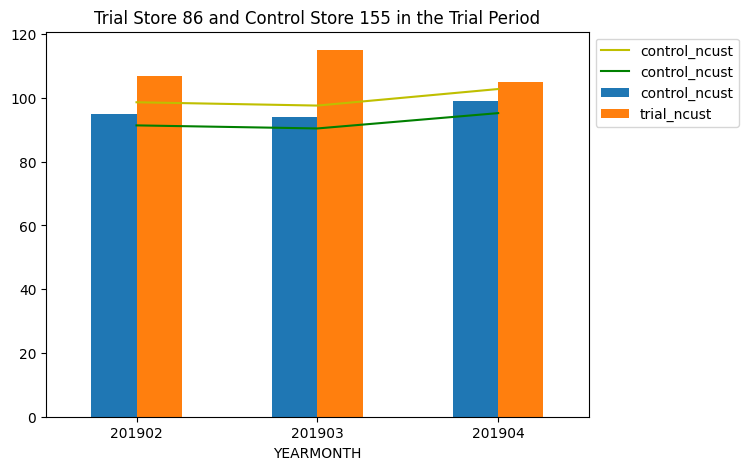

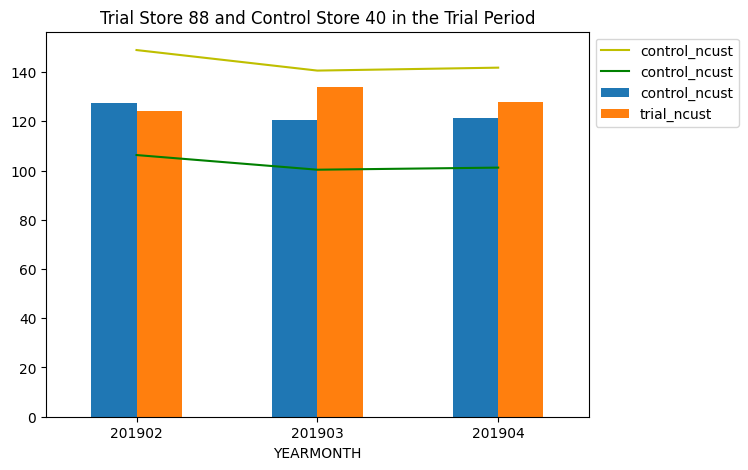

In [27]:
storepair = [[77, 233], [86, 155], [88, 40]]
for stores in storepair:
    trial = stores[0]
    control = stores[1]
    plot_control = percentdiff[(percentdiff['CONTROL_NBR'] == control) & (percentdiff.YEARMONTH >= 201902) & (percentdiff.YEARMONTH <= 201904)]\
                    [['YEARMONTH', 'CONTROL_NBR', 'scaled_n_cust_c']]
    plot_control = plot_control.rename(columns = {"CONTROL_NBR" : "STORE_NBR", "scaled_n_cust_c": "control_ncust"})
    plot_trial = percentdiff[(percentdiff['TRIAL_NBR'] == trial) & (percentdiff.YEARMONTH >= 201902) & (percentdiff.YEARMONTH <= 201904)]\
                    [['YEARMONTH', 'TRIAL_NBR', 'n_cust_t']]
    plot_trial = plot_trial.rename(columns = {"TRIAL_NBR" : "STORE_NBR", "n_cust_t": "trial_ncust"})
    toplot = plot_control[["YEARMONTH", "control_ncust"]].merge(plot_trial[["YEARMONTH", "trial_ncust"]],on="YEARMONTH").set_index("YEARMONTH")
    ax = toplot.plot(kind = 'bar',  figsize=(7, 5))

    # Thresholds
    std = percentdiff[(percentdiff['CONTROL_NBR'] == control) & (percentdiff.YEARMONTH < 201902)]['cust_percent_diff'].std()
    threshold95 = plot_control.reset_index()[['YEARMONTH', 'control_ncust']]
    threshold95.control_ncust = threshold95.control_ncust*(1+std*2)
    threshold5 = plot_control.reset_index()[['YEARMONTH', 'control_ncust']]
    threshold5.control_ncust = threshold5.control_ncust*(1-std*2)
    ax95 = threshold95.plot.line(x = 'YEARMONTH', y = 'control_ncust',color='y', figsize=(7, 5), use_index=False, ax = ax)
    ax5 = threshold5.plot.line(x = 'YEARMONTH', y = 'control_ncust', color='g', figsize=(7, 5), use_index=False, ax = ax)

    plt.legend(loc = "upper left",bbox_to_anchor=(1.0, 1.0))
    titlestr = 'Trial Store ' + str(trial) + ' and Control Store ' + str(control) + ' in the Trial Period'
    ax.set_title(titlestr)
    plt.show()

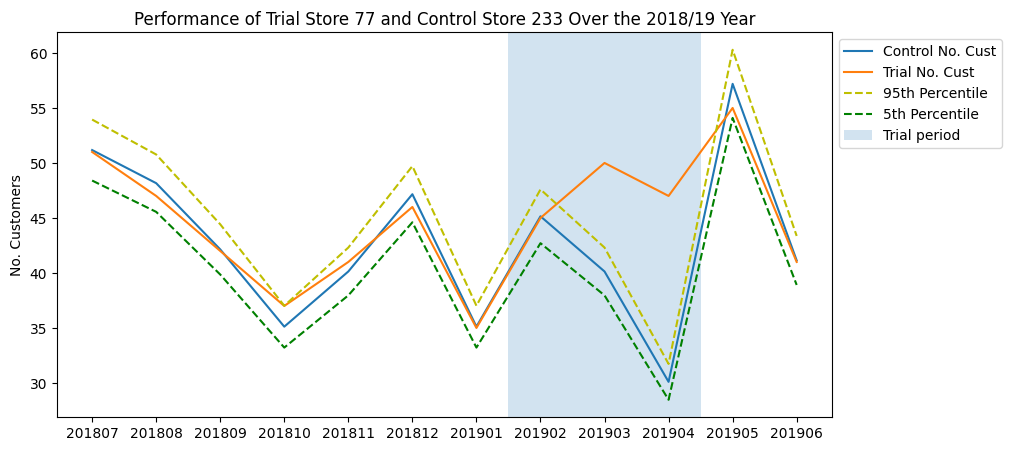

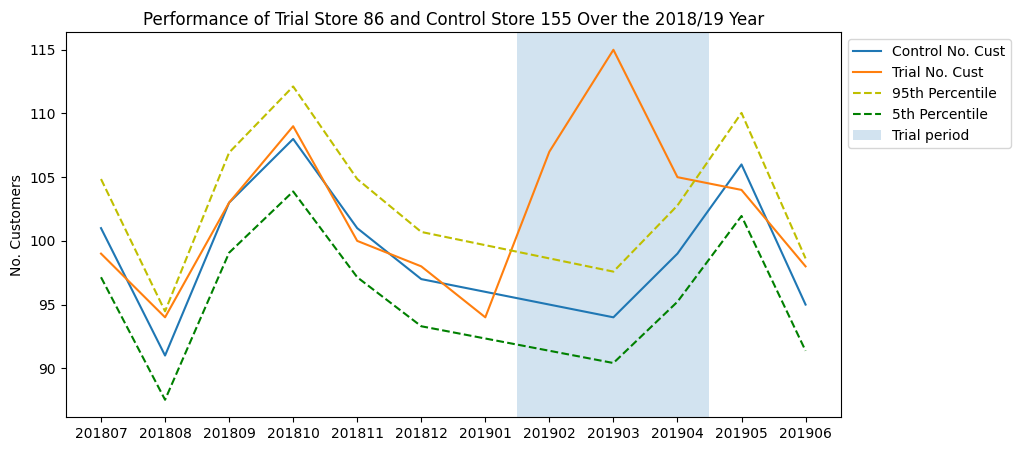

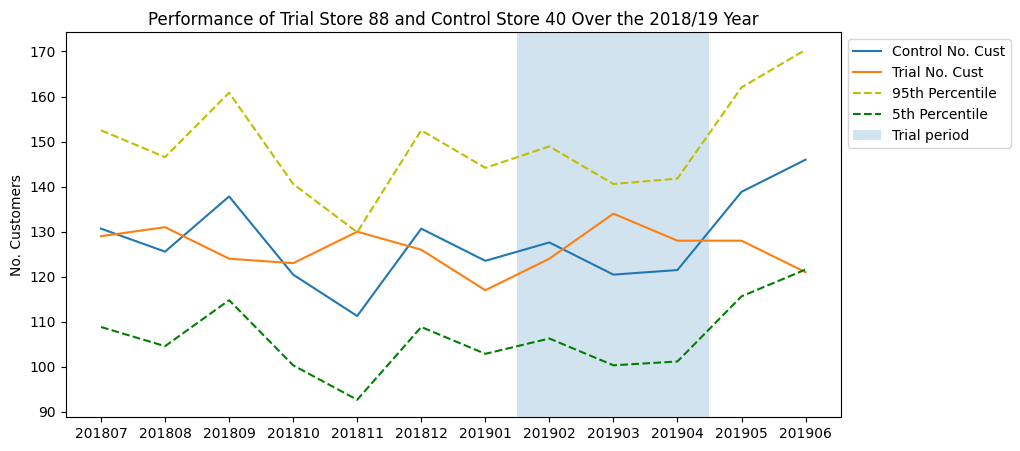

In [28]:
storepair = [[77, 233], [86, 155], [88, 40]]
for stores in storepair:
    trial = stores[0]
    control = stores[1]
    plot_control = percentdiff[(percentdiff['CONTROL_NBR'] == control)]\
                    [['YEARMONTH', 'CONTROL_NBR', 'scaled_n_cust_c']]
    plot_control = plot_control.rename(columns = {"CONTROL_NBR" : "STORE_NBR", "scaled_n_cust_c": "control_ncust"})
    plot_trial = percentdiff[(percentdiff['TRIAL_NBR'] == trial)]\
                    [['YEARMONTH', 'TRIAL_NBR', 'n_cust_t']]
    plot_trial = plot_trial.rename(columns = {"TRIAL_NBR" : "STORE_NBR", "n_cust_t": "trial_ncust"})

    ax = plot_control.plot.line(x = "YEARMONTH", y = 'control_ncust', use_index=False, label = 'Control No. Cust')
    ax_trial = plot_trial.plot.line(x = "YEARMONTH", y = 'trial_ncust', use_index=False, ax=ax, label = 'Trial No. Cust')

    # Thresholds
    std = percentdiff[(percentdiff['CONTROL_NBR'] == control) & (percentdiff.YEARMONTH < 201902)]['cust_percent_diff'].std()
    threshold95 = plot_control.reset_index()[['YEARMONTH', 'control_ncust']]
    threshold95.control_ncust = threshold95.control_ncust*(1+std*2)
    threshold5 = plot_control.reset_index()[['YEARMONTH', 'control_ncust']]
    threshold5.control_ncust = threshold5.control_ncust*(1-std*2)
    ax95 = threshold95.plot.line(x = 'YEARMONTH', y = 'control_ncust',color='y', linestyle = '--', figsize=(10, 5), use_index=False, ax = ax, label = '95th Percentile')
    ax5 = threshold5.plot.line(x = 'YEARMONTH', y = 'control_ncust', color='g',  linestyle = '--', figsize=(10, 5), use_index=False, ax = ax, label = '5th Percentile')
    ax.add_patch(Rectangle((6.5, 0), 3, 2000, alpha = 0.2, label = 'Trial period'))

    ax.set_ylabel('No. Customers')
    plt.legend(loc = "upper left",bbox_to_anchor=(1.0, 1.0))
    titlestr = 'Performance of Trial Store ' + str(trial) + ' and Control Store ' + str(control) + ' Over the 2018/19 Year'
    positions = (0,1,2,3,4,5,6,7,8,9, 10, 11)
    labels = ("201807", '201808', '201809', '201810', '201811', '201812', '201901', '201902', '201903', '201904', '201905', '201906')
    plt.xticks (positions, labels)
    ax.set_title(titlestr)
    plt.show()

The number of customers in stores 77 and 86 was noticeably higher throughout the three months, suggesting that the trial had a significant effect on increasing customer traffic in store 86. However, unlike store 77, the increase in total sales for store 86 didn't show as much statistical significance. Meanwhile, for store 88, there was no notable difference in customer numbers between the control and trial stores during the trial period, similar to the findings on total sales.